# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!gdown 'https://drive.google.com/uc?id=1pu_DDikwPzkysc8F0S-hko0k4Il1P7p_'

Downloading...
From: https://drive.google.com/uc?id=1pu_DDikwPzkysc8F0S-hko0k4Il1P7p_
To: /content/flickr.zip
1.11GB [00:10, 106MB/s] 


In [ ]:
!unzip flickr.zip

# Data

In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import os
import random
import sys

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
#%load_ext tensorboard.notebook

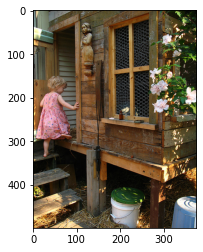

In [2]:
img = image.load_img('flickr/images/Flicker8k_Dataset/1000268201_693b08cb0e.jpg')
plt.imshow(img)

In [3]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
h, w = x.shape[1:3]
print(h, w)

500 375


In [4]:
import os
from tensorflow.keras.utils import Sequence

# Convert from RGB to Lab
"""
by iterating on each image, we convert the RGB to LAB. 
Think of LAB image as a grey image in L channel and all color info stored in A and B channels. 
The input to the network will be the L channel, so we assign L channel to X vector. 
And assign A and B to Y.
"""

class DataGenerator2D(Sequence):
    def __init__(self, base_path, img_size=256, batch_size=1, shuffle=True):
        self.base_path = base_path
        self.img_size = img_size
        self.id = os.listdir(base_path)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.ceil(len(self.id)/float(self.batch_size)))

    def __load__(self, id_name):
        image_path  = os.path.join(self.base_path, id_name)

        img = image.load_img(image_path, target_size=(self.img_size, self.img_size))
        img = image.img_to_array(img)
        lab = rgb2lab(img / 255.0)

        input_image = lab[:,:,0]
        # L channel(grayscale)
        output_image = (lab[:,:,1:] / 128)
        # A and B channels(colour information)

        input_image = np.array(input_image)
        output_image = np.array(output_image)

        input_image = input_image.reshape(input_image.shape+(1,))
        # converts (256, 256) -> (256, 256, 1)

        return input_image, output_image


    def __getitem__(self, index):
        if (index+1)*self.batch_size > len(self.id):
            file_batch = self.id[index*self.batch_size:]
        else:
            file_batch = self.id[index*self.batch_size:(index+1)*self.batch_size]
        
        bw_images, colour_images = [], []

        for id_name in file_batch:
            bw_img, color_img = self.__load__(id_name)
            bw_images.append(bw_img)
            colour_images.append(color_img)

        bw_images = np.array(bw_images)
        colour_images  = np.array(colour_images)

        return bw_images, colour_images


    def on_epoch_end(self):
        self.indexes = np.arange(len(self.id))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [5]:
train_generator = DataGenerator2D('flickr/images/Flicker8k_Dataset/', img_size=256, batch_size=64, shuffle=True)

In [6]:
X, y = train_generator.__getitem__(0)
print(X.shape, y.shape)

(64, 256, 256, 1) (64, 256, 256, 2)


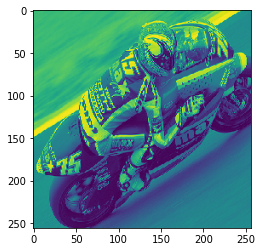

In [7]:
# L channel
plt.imshow(X[0].reshape(256, 256))

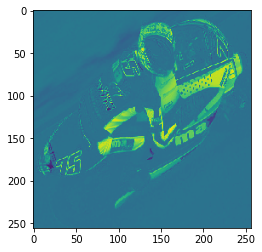

In [8]:
# A channel
plt.imshow(y[0,:,:,0])

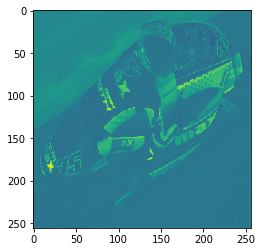

In [9]:
# B channel
plt.imshow(y[0,:,:,1])

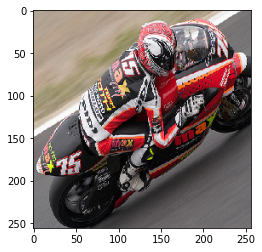

In [10]:
# Rebuilt image
y = y*128
result = np.zeros((256, 256, 3))
result[:,:,0] = X[0][:,:,0]
result[:,:,1:] = y[0]
plt.imshow(lab2rgb(result))

# Model

In [11]:
model = Sequential()

# Encoder
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

# Decoder
# NOTE: For the last layer we use tanh instead of Relu. 
# This is because we are colorizing the image in this layer using 2 filters, A and B.
# A and B values range between -1 and 1 so tanh (or hyperbolic tangent) is used
# as it also has the range between -1 and 1. 
# Other functions go from 0 to 1.
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 512)       1180160   
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 512)       2

In [12]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="drive/My Drive/models/image-colorization/" + "Autoencoder-" + "epoch-{epoch:02d}-loss-{loss:.6f}.hdf5", verbose=1)

history = model.fit(train_generator,
                    steps_per_epoch=125,
                    callbacks=[cp_callback],
                    epochs = 100,
                    verbose=1)

model.save('drive/My Drive/models/image-colorization/Autoencoder100.hdf5')

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 0.0307 - accuracy: 0.6163
Epoch 00001: saving model to drive/My Drive/models/image-colorization/Autoencoder-epoch-01-loss-0.030723.hdf5
125/125 [==============================] - 176s 1s/step - loss: 0.0307 - accuracy: 0.6163
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.6199
Epoch 00002: saving model to drive/My Drive/models/image-colorization/Autoencoder-epoch-02-loss-0.014227.hdf5
125/125 [==============================] - 176s 1s/step - loss: 0.0142 - accuracy: 0.6199
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.6192
Epoch 00003: saving model to drive/My Drive/models/image-colorization/Autoencoder-epoch-03-loss-0.014018.hdf5
125/125 [==============================] - 174s 1s/step - loss: 0.0140 - accuracy: 0.6192
Epoch 4/100
125/125 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.6194
Epoch 00004:

(1, 256, 256, 3)
(1, 256, 256)
(1, 256, 256, 1)


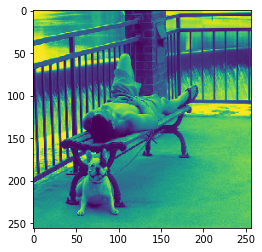

In [13]:
# model = tf.keras.models.load_model("drive/My Drive/models/image-colorization/Autoencoder100.hdf5")

img_color = []

img = image.img_to_array(image.load_img('flickr/images/Flicker8k_Dataset/1003163366_44323f5815.jpg', target_size=(256,256)))
img_color.append(img)

img_color = np.array(img_color, dtype=float)
print(img_color.shape)
img_color = rgb2lab(img_color/255.0)[:,:,:,0]
print(img_color.shape)
img_color = img_color.reshape(img_color.shape+(1,))
print(img_color.shape)

plt.imshow(rgb2lab(img/255.0)[:,:,0])

In [14]:
output = model.predict(img_color)
output.shape

(1, 256, 256, 2)

In [15]:
output = output*128

result = np.zeros((256, 256, 3))
result[:,:,0] = img_color[0][:,:,0]
result[:,:,1:] = output[0]
result.shape

(256, 256, 3)

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 14 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


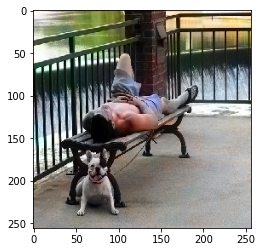

In [16]:
plt.imshow(lab2rgb(result))

# Reconstructed Models

In [18]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import os
import random
import sys

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
#%load_ext tensorboard.notebook

In [19]:
reconstructed_model = tf.keras.models.load_model("drive/My Drive/models/image-colorization/Autoencoder-epoch-95-loss-0.003109.hdf5")

(1, 256, 256, 3)
(1, 256, 256)
(1, 256, 256, 1)


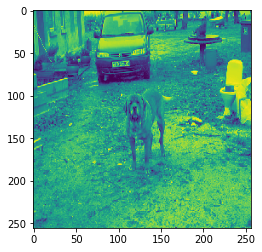

In [59]:
img_color = []

img = image.img_to_array(image.load_img('flickr/images/Flicker8k_Dataset/2098418613_85a0c9afea.jpg', target_size=(256,256)))
img_color.append(img)

img_color = np.array(img_color, dtype=float)
print(img_color.shape)
img_color = rgb2lab(img_color/255.0)[:,:,:,0]
print(img_color.shape)
img_color = img_color.reshape(img_color.shape+(1,))
print(img_color.shape)

plt.imshow(rgb2lab(img/255.0)[:,:,0])

In [60]:
output = reconstructed_model.predict(img_color)
output.shape

(1, 256, 256, 2)

In [61]:
output = output*128

result = np.zeros((256, 256, 3))
result[:,:,0] = img_color[0][:,:,0]
result[:,:,1:] = output[0]
result.shape

(256, 256, 3)

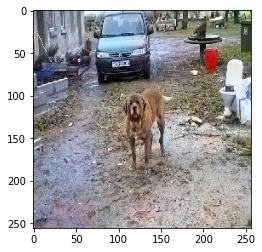

In [62]:
plt.imshow(lab2rgb(result))